# EuroSat Image Classification using AlexNet

Hector Becerra  
Juan Terven  
2023

In this Notebook we train **AlexNet**  
**AlexNet** is a seminal convolutional neural network (CNN) architecture that played a pivotal role in the field of deep learning, particularly in computer vision. Developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, it was introduced in 2012 and won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC). The architecture features eight layers, including five convolutional layers followed by three fully connected layers, and it incorporates innovative elements such as ReLU (Rectified Linear Unit) activation functions, dropout layers to prevent overfitting, and data augmentation techniques. AlexNet's success in significantly reducing error rates for image classification tasks marked a watershed moment, propelling deep learning to the forefront of artificial intelligence research and application.

In [1]:
import os
import numpy as np 
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wandb
from torch.utils.data import DataLoader
import json
from torchvision.models import alexnet,AlexNet_Weights

from train_utils import get_predictions,compute_val_loss,EarlyStopping,train_model
from eval_utils import remove_wandb_hooks,evaluate_test_set,precision_recall_analysis
from EuroSAT import EurosatDataset,visualize_classes


In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print("Found GPU")
else:
    torch.device("cpu")
    
print("Pytorch version:", torch.__version__)

Found GPU
Pytorch version: 1.12.1+cu116


## Login to Wandb to log experiment

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'EuroSat_AlexNet_Classifier.ipynb'

wandb.login()

wandb: Currently logged in as: jrterven. Use `wandb login --relogin` to force relogin


True

# Data
The [EuroSat Dataset](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8736785) consists of 27,000 labeled images with ten different land use and land cover classes. It is multi-spectral, covering 13 spectral bands in the visible, near infrared, and short wave infrared parts of the spectrum. The dataset is geo-referenced and based on openly and freely accessible earth observation data. The classes are the following.

| No. | Land Use Type           |
|-----|-------------------------|
| 1   | AnnualCrop              |
| 2   | Forest                  |
| 3   | HerbaceousVegatation    |
| 4   | Highway                 |
| 5   | Industrial              |
| 6   | Pasture                 |
| 7   | PermanentCrop           |
| 8   | Residential             |
| 9   | River                   |
| 10  | SeaLake                 |

In [3]:
data_path = "/datasets/eurosat/EuroSAT/"

In [4]:
# Load the labels 
f = open(f"{data_path}label_map.json", "r")
label_to_index = json.load(f)

In [5]:
index_to_label = {label_to_index[k]:k for k in label_to_index}
print(index_to_label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


## Data Transformations

In [6]:
# Define a sequence of transformations to be applied to images
transformToTensor = transforms.Compose([
    # Resize the image to have a minimum size of 64 pixels along the shortest dimension,
    # preserving the aspect ratio of the original image.
    transforms.Resize((64,)),

    # Crop the image at the center to get a 64x64 square.
    transforms.CenterCrop((64, 64)),

    # Convert the image to a PyTorch tensor.
    transforms.ToTensor(),

    # Normalize the tensor image with mean and standard deviation for each color channel.
    # These specific values are generally used for pre-trained models.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create dataset instances
# Instantiate the EurosatDataset class for training data.
train_dataset = EurosatDataset(_type='train', transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for validation data.
valid_dataset = EurosatDataset(_type="valid", transform=transformToTensor,
                               data_path=data_path)

# Instantiate the EurosatDataset class for testing data.
test_dataset = EurosatDataset(_type="test", transform=transformToTensor,
                              data_path=data_path)

# Define batch sizes for training and validation data.
train_batch = 64  # The batch size for training data.
val_batch = 16     # The batch size for validation data.

# Create DataLoaders
# Create a DataLoader for the training dataset. This DataLoader will automatically
# group the training data into batches of size 128 and shuffle them in each epoch.
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)

# Create a DataLoader for the validation dataset. This DataLoader groups the validation
# data into batches of size 32. The data is not shuffled, which is typical for validation data.
valid_loader = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)

# Create a DataLoader for the testing dataset. This DataLoader processes the test data
# one sample at a time (batch size of 1) and does not shuffle the data. This is typical
# for test data since we often want to evaluate the model on test data in a specific order.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

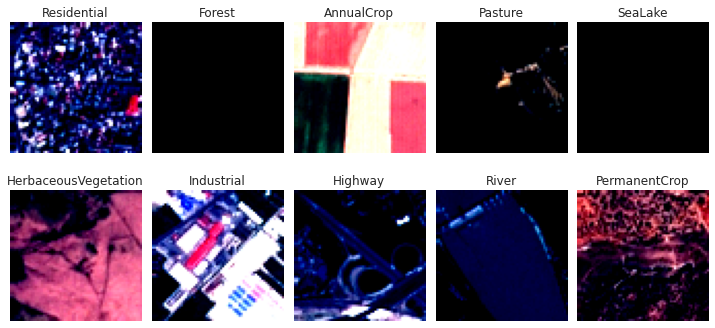

In [8]:
visualize_classes(train_loader, index_to_label)

In [9]:
dataset_managers = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader
}

print(f"Train set batches: {len(train_loader)}")
print(f"Validation set batches: {len(valid_loader)}")
print(f"Test set examples: {len(test_loader)}")

Train set batches: 296
Validation set batches: 338
Test set examples: 2700


## Labels distribution

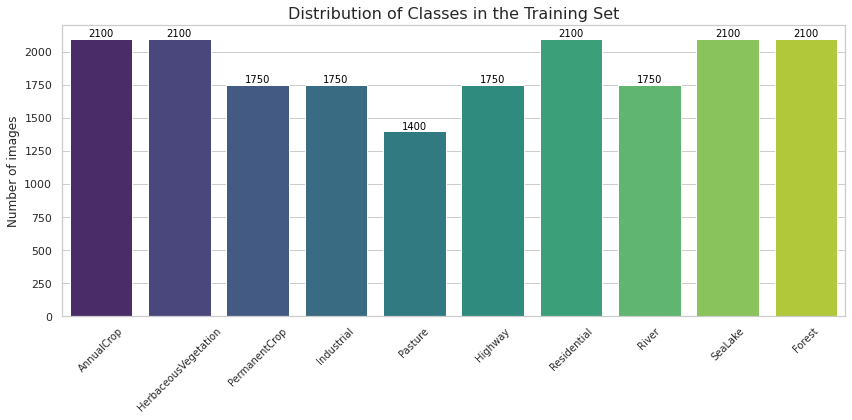

In [10]:
labels = train_dataset.data['Label'].values  # Assuming 'Label' is the column with labels

# Convert numerical labels to string names if necessary
label_names = [index_to_label[label] for label in labels]

sns.set(style="whitegrid")  # Set style
plt.figure(figsize=(12, 6))

# Adjusted according to the new API
ax = sns.countplot(x=label_names, hue=label_names, palette="viridis", legend=False)

#plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.title('Distribution of Classes in the Training Set', fontsize=16)
plt.xticks(rotation=45, fontsize=10)

# Add the count above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



# Model

In [12]:
# weights = AlexNet_Weights.DEFAULT

# # Use pretrained model
# model_pretrained=alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# Use un-pretrained model
model = alexnet()

# Replace the model head with the number of classes
num_classes = 10
model.classifier[6] = nn.Linear(4096, num_classes) 
model.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Training model from Scratch

In [16]:
project_name = "EuroSAT"
model_name = "AlexNet"
models_path = "/datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models"

In [13]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="AlexNet from scratch",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 2.286455249786377
Step: 41/296 Loss: 1.950124043226242
Step: 61/296 Loss: 1.8011057436466218
Step: 81/296 Loss: 1.6594646394252777
Step: 101/296 Loss: 1.5183053374290467
Step: 121/296 Loss: 1.5568811535835265
Step: 141/296 Loss: 1.353336101770401
Step: 161/296 Loss: 1.3009010791778564
Step: 181/296 Loss: 1.2800263464450836
Step: 201/296 Loss: 1.2061630606651306
Step: 221/296 Loss: 1.2750308334827423
Step: 241/296 Loss: 1.2130502343177796
Step: 261/296 Loss: 1.1231491267681122
Step: 281/296 Loss: 1.0892385065555572
Validation Loss: 1.1951 Accuracy: 0.5383
Epoch duration: 49.64s

Epoch: 2...
Step: 21/296 Loss: 1.1832283049821855
Step: 41/296 Loss: 1.00688938498497
Step: 61/296 Loss: 0.94638412296772
Step: 81/296 Loss: 0.9537244856357574
Step: 101/296 Loss: 0.8622789680957794
Step: 121/296 Loss: 0.9570851057767868
Step: 141/296 Loss: 0.8713753283023834
Step: 161/296 Loss: 0.81944

Step: 41/296 Loss: 0.20483172871172428
Step: 61/296 Loss: 0.23207521811127663
Step: 81/296 Loss: 0.2578354887664318
Step: 101/296 Loss: 0.24530945718288422
Step: 121/296 Loss: 0.19558581486344337
Step: 141/296 Loss: 0.18287308886647224
Step: 161/296 Loss: 0.21068417727947236
Step: 181/296 Loss: 0.24295805767178535
Step: 201/296 Loss: 0.24820522889494895
Step: 221/296 Loss: 0.23995074927806853
Step: 241/296 Loss: 0.2854919970035553
Step: 261/296 Loss: 0.22355091907083988
Step: 281/296 Loss: 0.23036606907844542
Validation Loss: 0.5007 Accuracy: 0.8509
Epoch duration: 47.96s

Epoch: 15...
Step: 21/296 Loss: 0.20776374228298664
Step: 41/296 Loss: 0.1813409613445401
Step: 61/296 Loss: 0.23976450003683566
Step: 81/296 Loss: 0.17594339922070504
Step: 101/296 Loss: 0.17831951919943095
Step: 121/296 Loss: 0.19504638612270356
Step: 141/296 Loss: 0.1713896457105875
Step: 161/296 Loss: 0.19957587718963624
Step: 181/296 Loss: 0.19710279647260903
Step: 201/296 Loss: 0.20249844826757907
Step: 221/296

## Save model

In [14]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EuroSAT-AlexNet.pth


In [15]:
# Save the loss data in a file
with open(f"{models_path}/loss_alexnet.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

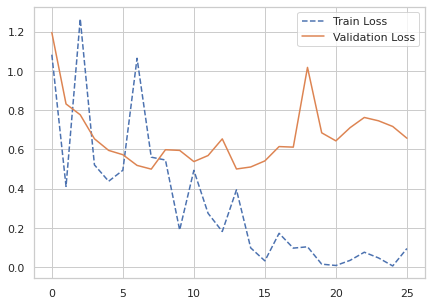

In [16]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [17]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
model.load_state_dict(torch.load(f = model_save_path))

<All keys matched successfully>

In [18]:
evaluate_test_set(model, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.856     0.853     0.855       300
              Forest      0.864     0.973     0.915       300
HerbaceousVegetation      0.793     0.767     0.780       300
             Highway      0.669     0.656     0.663       250
          Industrial      0.906     0.888     0.897       250
             Pasture      0.856     0.775     0.814       200
       PermanentCrop      0.726     0.752     0.739       250
         Residential      0.962     0.917     0.939       300
               River      0.741     0.880     0.804       250
             SeaLake      0.996     0.863     0.925       300

            accuracy                          0.837      2700
           macro avg      0.837     0.832     0.833      2700
        weighted avg      0.842     0.837     0.838      2700



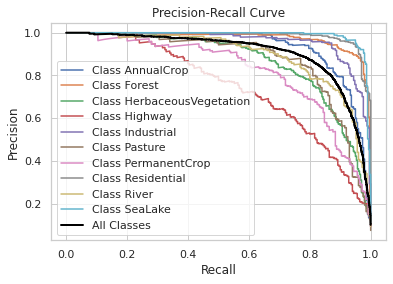

In [39]:
precision_recall_analysis(model, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [21]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇▇█████▆▇██▇███
val_loss,█▄▄▃▂▂▁▁▂▂▁▂▃▁▁▁▂▂▆▃▂▃▄▃▃▃
epoch,25
step,7680
train_loss,0.15249
val_accuracy,0.84148
val_loss,0.65729


## Load the precision/recall curve and plot it

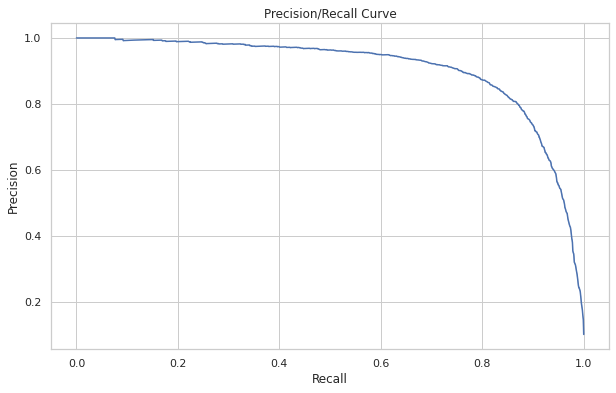

In [42]:
filename = f"{model_name}_precision_recall_values.json"
file_path = os.path.join(models_path, filename)

with open(file_path, 'r') as file:
    precision_recall_data = json.load(file)
    
all_classes_data = precision_recall_data['All Classes']

# Extract precision and recall values
precisions = all_classes_data.get('precision', [])
recalls = all_classes_data.get('recall', [])

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls
})

# Plotting the precision/recall curve
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Recall', y='Precision')
plt.title('Precision/Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Clean-up

In [44]:
import gc

del model
torch.cuda.empty_cache()
gc.collect()


802

# Now train the model with pre-trained weights

In [22]:
# Use pretrained model
model2=alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# Replace the model head with the number of classes
num_classes = 10
model2.classifier[6] = nn.Linear(4096, num_classes) 
model2.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Train

In [23]:
project_name = "EuroSAT"
model_name = "AlexNet-Pretrained"
models_path = "/datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models"

In [46]:
epochs = 200
lr = 0.0001
patience = 10

run = wandb.init(
    # Set the project where this run will be logged
    project=project_name,
    name=model_name,
    notes="AlexNet pre-trained ImageNet",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": train_batch,
        "patience": patience
    })

loss_i, loss_val_i = train_model(model=model2, epochs=epochs, 
                                 train_loader=train_loader,
                                 valid_loader=valid_loader,
                                 lr=lr, patience=patience, device=DEVICE)

Starting training with early stopping patience of 10
Each epoch has 296 steps.

Epoch: 1...
Step: 21/296 Loss: 1.0758148774504661
Step: 41/296 Loss: 0.6079859241843224
Step: 61/296 Loss: 0.4497781157493591
Step: 81/296 Loss: 0.43623129427433016
Step: 101/296 Loss: 0.425557416677475
Step: 121/296 Loss: 0.4209266796708107
Step: 141/296 Loss: 0.3372033812105656
Step: 161/296 Loss: 0.37313012555241587
Step: 181/296 Loss: 0.36140263453125954
Step: 201/296 Loss: 0.3488378431648016
Step: 221/296 Loss: 0.30952207297086715
Step: 241/296 Loss: 0.30467390194535254
Step: 261/296 Loss: 0.29657170698046686
Step: 281/296 Loss: 0.2673257552087307
Validation Loss: 0.2835 Accuracy: 0.8991
Epoch duration: 48.65s

Epoch: 2...
Step: 21/296 Loss: 0.202768774330616
Step: 41/296 Loss: 0.174042375292629
Step: 61/296 Loss: 0.17966386079788207
Step: 81/296 Loss: 0.1930881753563881
Step: 101/296 Loss: 0.2232887353748083
Step: 121/296 Loss: 0.18128814846277236
Step: 141/296 Loss: 0.16268173102289438
Step: 161/296 

Step: 261/296 Loss: 0.02750077274395153
Step: 281/296 Loss: 0.053841484000440684
Validation Loss: 0.3865 Accuracy: 0.9152
Epoch duration: 48.24s

Early stopping invoked in epoch 13


## Save model

In [47]:
# Create models directory
os.makedirs(models_path, exist_ok=True)

# 2. Create model save path
model_save_path = os.path.join(models_path, model_name + ".pth")

# 3. Save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/EuroSAT-AlexNet-Pretrained.pth


In [48]:
# Save the loss data in a file
with open(f"{models_path}/loss_{model_name}.txt", "w") as archivo:
    archivo.write(f"loss_i: {loss_i}\n")
    archivo.write(f"loss_val_i: {loss_val_i}\n")

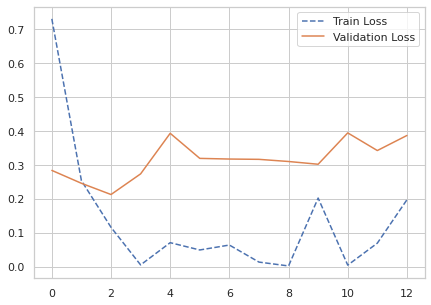

In [49]:
plt.figure(figsize=(7,5))
# Use a dashed line for the training loss, and add markers
plt.plot(loss_i, label="Train Loss", linestyle='--', alpha=1.0)

# Use a solid line for the validation loss
plt.plot(loss_val_i, label="Validation Loss", linestyle='-', alpha=1.0)
plt.legend()
plt.show()

# Evaluate model

In [25]:
# Call this function before evaluating your model to remove any wandb hook
#remove_wandb_hooks(model)

## Load trained model

In [24]:
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
model_save_path = models_path + "/" + model_name + ".pth"
print(f"Loading {model_save_path}")
model2.load_state_dict(torch.load(f = model_save_path))

Loading /datasets2/Dropbox/Projects/remote_sensing/LC_classification_pytorch/models/AlexNet-Pretrained.pth


<All keys matched successfully>

In [25]:
evaluate_test_set(model2, test_loader, DEVICE, index_to_label=index_to_label)

                      precision    recall  f1-score   support

          AnnualCrop      0.938     0.950     0.944       300
              Forest      0.832     0.993     0.906       300
HerbaceousVegetation      0.907     0.913     0.910       300
             Highway      0.861     0.844     0.853       250
          Industrial      0.928     0.976     0.951       250
             Pasture      0.906     0.725     0.806       200
       PermanentCrop      0.909     0.836     0.871       250
         Residential      0.993     0.990     0.992       300
               River      0.886     0.872     0.879       250
             SeaLake      0.997     0.973     0.985       300

            accuracy                          0.916      2700
           macro avg      0.916     0.907     0.910      2700
        weighted avg      0.918     0.916     0.915      2700



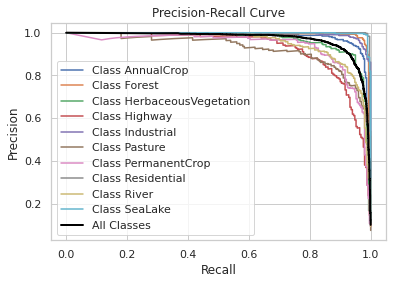

In [54]:
precision_recall_analysis(model2, test_loader, DEVICE,
                          output_path=models_path,
                          model_name=model_name,
                          index_to_label=index_to_label)

In [55]:
wandb.finish()

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▆▅▄▃▃▃▂▃▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃█▅▃▇▇▆▇▇▄█▄
val_loss,▄▂▁▃█▅▅▅▅▄█▆█
epoch,12
step,3832
train_loss,0.05384
val_accuracy,0.91519
val_loss,0.38649
